经过尝试发现jieba分词中关键词提取表现最好。在这里对比了jieba关键词提取、jieba分词与pkuseg的表现。其中所有方法都去除了停止词。pkuseg中使用了"web"模型（即在微博语料训练的模型），但未加入词典。

渣代码警告：没有特别优化过，随便写的。

单线程警告：由于没有优化过代码加上jupyter notebook的缘故，只能跑单线程。因此你的小电脑可能需要跑一段时间。

内存警告：这个代码比较吃内存（尤其是图片显示。调低create_wordcloud函数中的dpi和scale会加快图片显示和减小内存）。

In [1]:
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from PIL import Image
import pkuseg
import jieba
import jieba.analyse
jieba.load_userdict('词典.txt')
#https://github.com/goto456/stopwords/
jieba.analyse.set_stop_words('停用词表.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Administrator\AppData\Local\Temp\jieba.cache
Loading model cost 0.815 seconds.
Prefix dict has been built succesfully.


In [2]:
# 加载数据
comment_data = np.load('comment_cleaned.npz')["arr_0"]

In [3]:
def add_count(count, element_list):
    for element in element_list:
        if str(element) in count.keys():
            count[str(element)] += 1
        else:
            count[str(element)] = 1
    return count


def merge_two_dicts(x, y):
    return {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}


def stopwordslist(file_path):
    stopwords = [
        line.strip() for line in open(file_path, encoding='UTF-8').readlines()
    ]
    return stopwords


def create_wordcloud(word_count,
                     mask=None,
                     color_with_mask=False,
                     height=8,
                     weigth=8,
                     dpi=400,
                     scale=32,
                     save_name=None):
    if mask:
        mask = np.array(Image.open(mask))  # 定义词频背景
    else:
        color_with_mask = None  #确保在有mask图像时再使用color_with_mask
    wc = wordcloud.WordCloud(
        font_path='C:/Windows/Fonts/simhei.ttf',  # 设置字体格式
        mask=mask,  # 设置背景图
        max_words=200,  # 最多显示词数
        max_font_size=100,  # 字体最大值
        scale=scale,  # 规模/分辨率/清晰程度
        # background_color="white",
    )
    plt.figure(figsize=(height, weigth), dpi=dpi)
    wc.generate_from_frequencies(word_count)  # 从字典生成词云
    if color_with_mask:
        image_colors = wordcloud.ImageColorGenerator(mask)  # 从背景图建立颜色方案
        wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图方案
    plt.imshow(wc)  # 显示词云
    plt.axis('off')  # 关闭坐标轴
    if save_name:
        plt.savefig(save_name)
    plt.show()  # 显示图像

# 结巴关键词提取

In [4]:
comment_join = ''.join(comment_data) #需要先把评论合并才能提取关键词
tags = jieba.analyse.extract_tags(comment_join, topK=200, withWeight=True) #提取前两百个关键词

In [5]:
print({name:round(value,4) for name,value in dict(tags[:100]).items()}) #查看前一百的词频

{'孙哥': 0.1601, '带哥': 0.0921, '无内鬼': 0.0608, '进来': 0.0585, '真的': 0.0465, 'gkd': 0.0465, '粉丝': 0.0464, '弟弟': 0.0462, '微博': 0.0453, '孙笑川': 0.0449, '哈哈哈': 0.0429, '孙狗': 0.0419, '呜呜': 0.0393, '寻思': 0.0311, '我佛': 0.0302, '蔡徐坤': 0.0295, 'kkp': 0.0276, '安排': 0.0271, '原图': 0.0267, 'biss': 0.0266, '建议': 0.0262, '评论': 0.0261, '冲冲': 0.025, '完事': 0.025, '牛批': 0.0247, 'tony': 0.0245, '崽种': 0.0242, '环节': 0.0231, 'nmsl': 0.0223, '回复': 0.021, '击毙': 0.0199, '喜欢': 0.0194, '属实': 0.0191, '今晚': 0.0189, '铁汁': 0.0188, '直播': 0.0188, '个崽种': 0.0187, '哥哥': 0.0187, '司马': 0.0178, '抽象': 0.0177, '明星': 0.0175, '加大力度': 0.0168, '快点': 0.0167, '暗示': 0.0166, '咖喱': 0.0164, '一个': 0.0158, '恶人': 0.0157, '一哈': 0.0151, 'hape': 0.015, '激光': 0.0149, '老子': 0.0148, '求求': 0.0143, 'ikun': 0.014, '恰个': 0.0139, '排面': 0.0138, '别人': 0.0137, '哈哈哈哈': 0.0132, '热度': 0.0129, '梁木': 0.0124, '滚出克': 0.0123, '必死': 0.0121, '发点': 0.0118, '小改改': 0.0118, '不用': 0.0117, 'Tony': 0.0117, '哥们': 0.0116, '给力': 0.0116, '自闭': 0.0116, '孤儿': 0.0115, '我要': 0.0113,

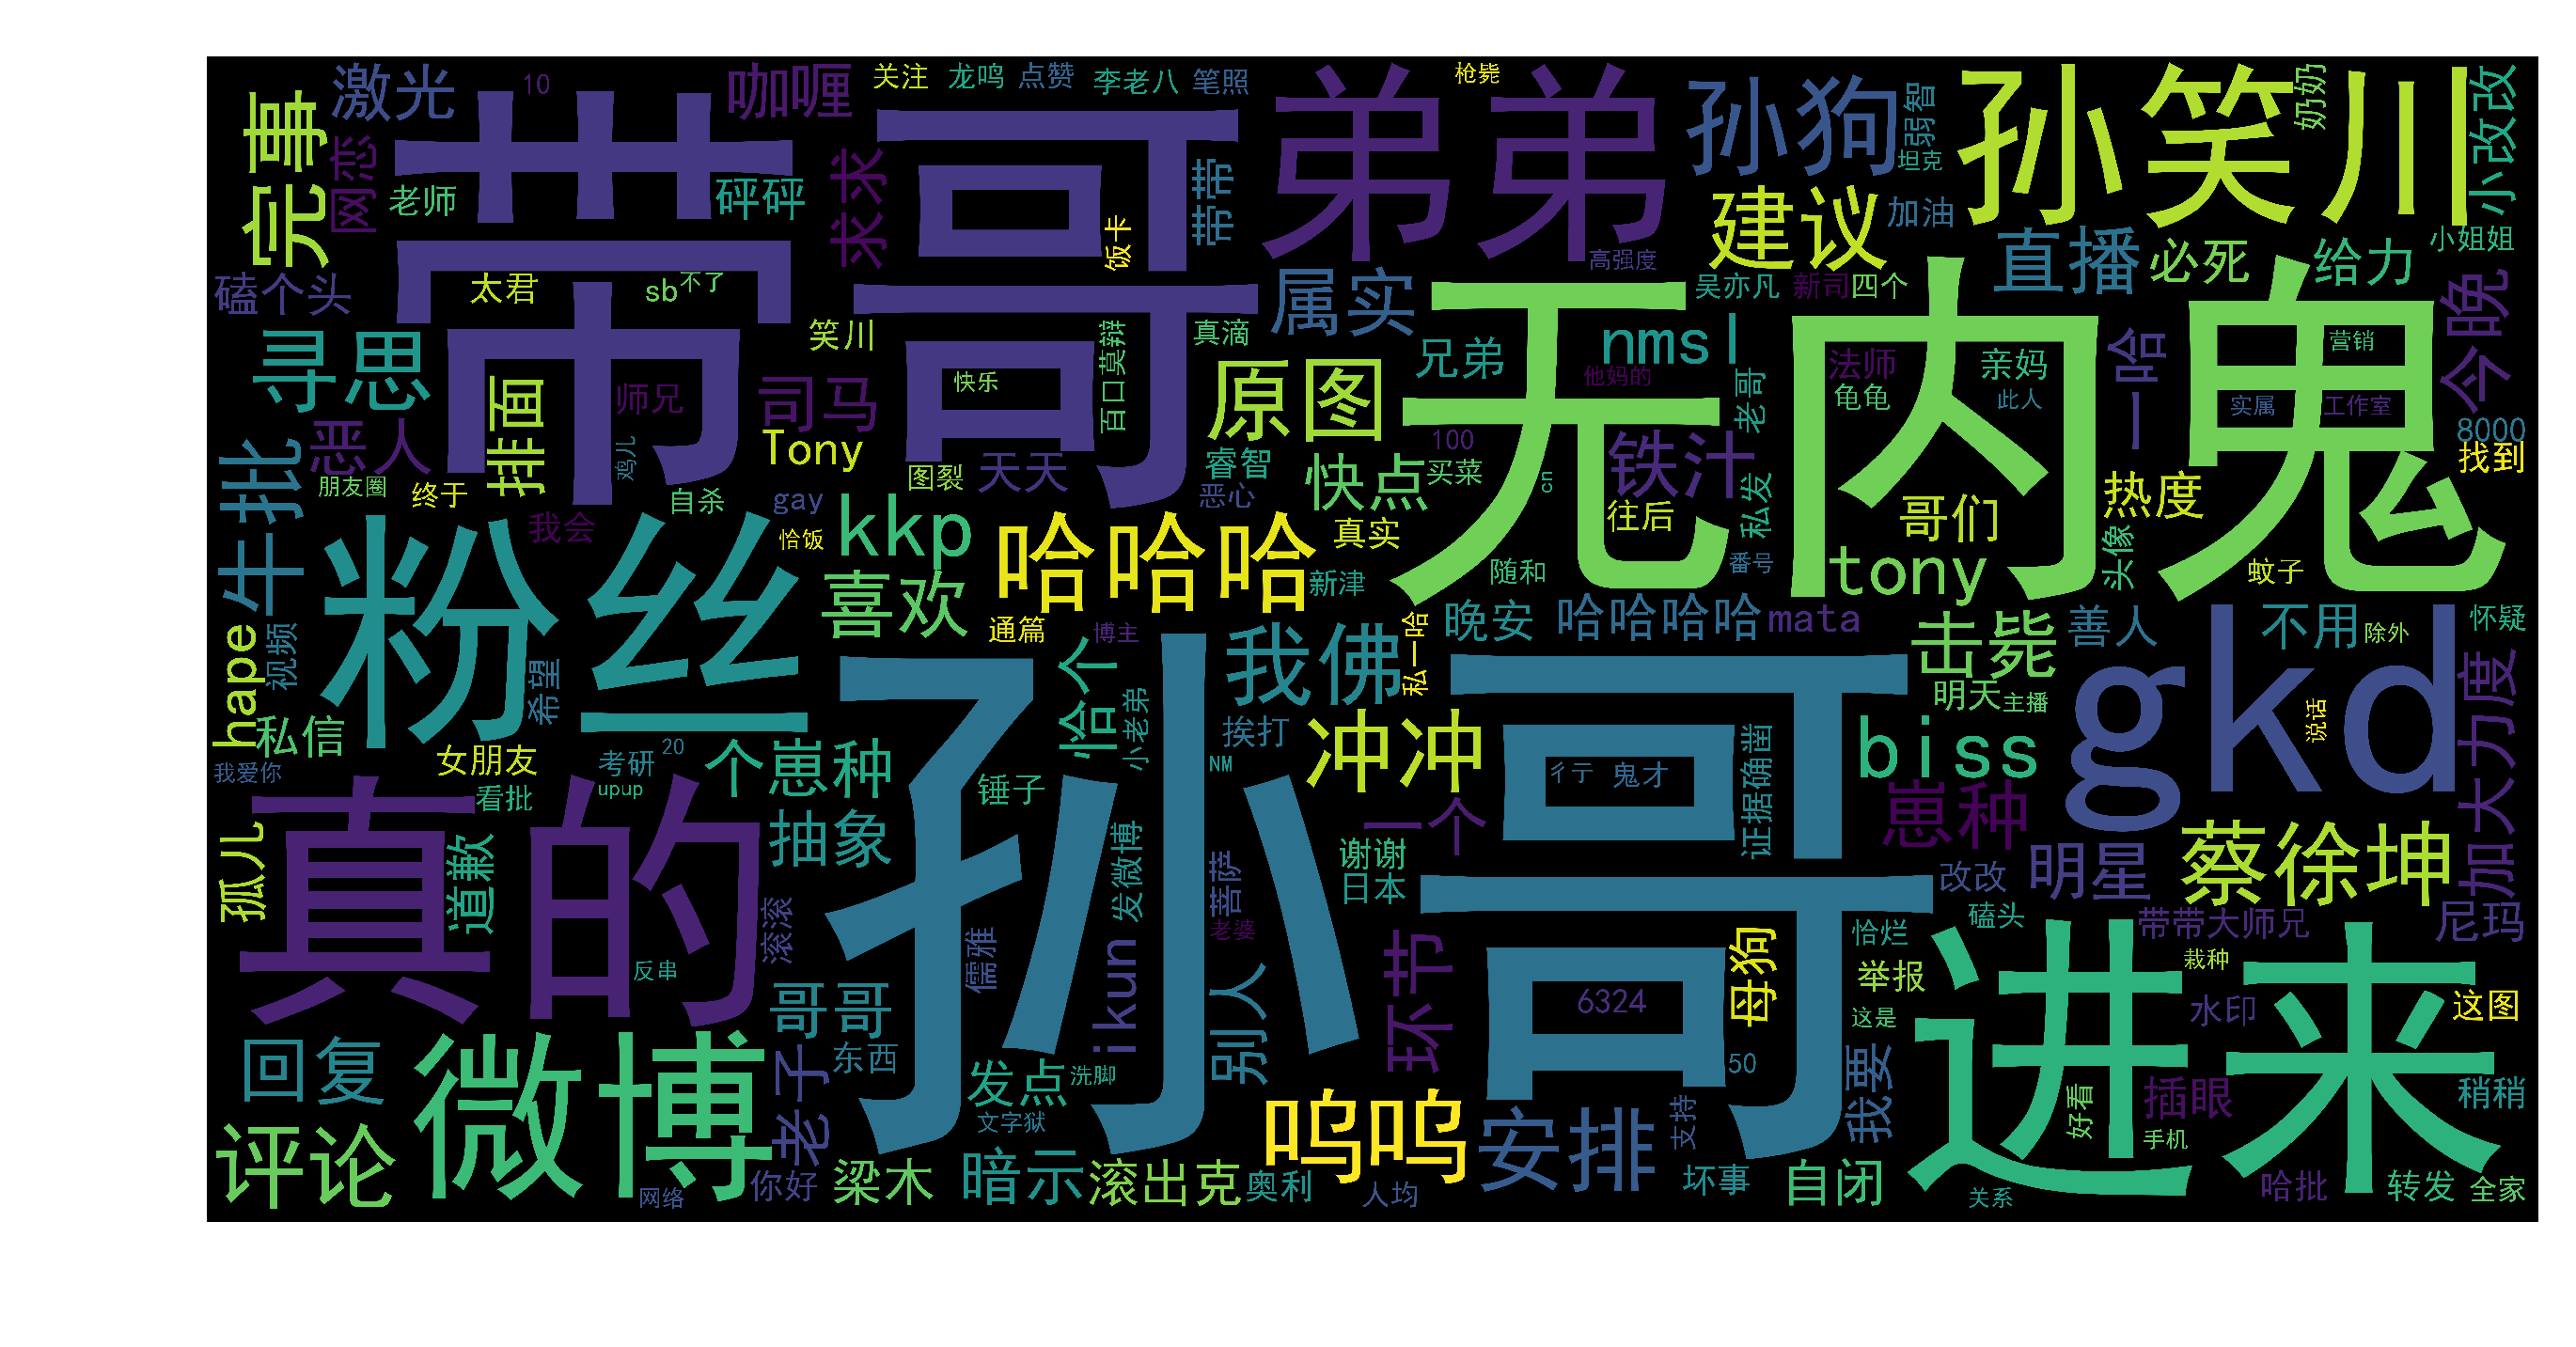

In [6]:
create_wordcloud(dict(tags))

# 结巴分词

In [7]:
word_count_jieba = {}
for comment in comment_data:
    word_list_jieba = jieba.cut(comment)
    word_count_jieba = add_count(word_count_jieba, word_list_jieba)

stopwords = stopwordslist('停用词表.txt')
word_count_jieba_without_stopword = {}
for word, freq in word_count_jieba.items():
    if word not in stopwords:
        word_count_jieba_without_stopword[word] = freq

word_count_jieba_without_stopword_sort = sorted(word_count_jieba_without_stopword.items(),
                                          key=lambda item: int(item[1]),
                                          reverse=True)

In [8]:
print(word_count_jieba_without_stopword_sort[:100]) #查看前一百的词频

[(' ', 784215), ('，', 662491), ('？', 444453), ('。', 110164), ('！', 87056), ('都', 82297), ('不', 80166), ('孙哥', 64940), ('说', 61287), ('嚯', 57589), ('人', 55843), ('带', 54914), ('还', 54892), ('️', 53371), ('进来', 49255), ('看', 47272), ('嗷', 44314), ('死', 41293), ('真的', 39995), ('带哥', 38979), ('没', 36913), ('丶', 35633), ('好', 35443), ('孙', 33904), ('弟弟', 30957), ('去', 29061), ('¿', 27790), ('/', 27625), ('一个', 27134), ('上', 26623), ('8', 26398), ('想', 25130), ('臭', 25084), ('无内鬼', 24620), ('建议', 24204), ('粉丝', 24116), ('安排', 22753), ('gkd', 22000), ('呜呜', 21814), ('哈哈哈', 21038), ('妈', 20656), ('发', 19660), (':', 19516), ('我佛', 19454), ('透', 18948), ('微博', 18947), ('寻思', 18757), ('评论', 18623), ('.', 18491), ('坤', 18487), ('孙笑川', 18182), ('搞', 18141), ('笑', 17732), ('必', 17221), ('孙狗', 16999), ('：', 16640), ('喜欢', 16480), ('会', 16413), ('憨', 16323), ('太', 16189), ('=', 15813), ('环节', 15714), ('吃', 15701), ('、', 15603), ('骂', 15462), ('做', 15358), ('🌶', 14994), ('大', 14780), ('脸', 14670), ('滚'

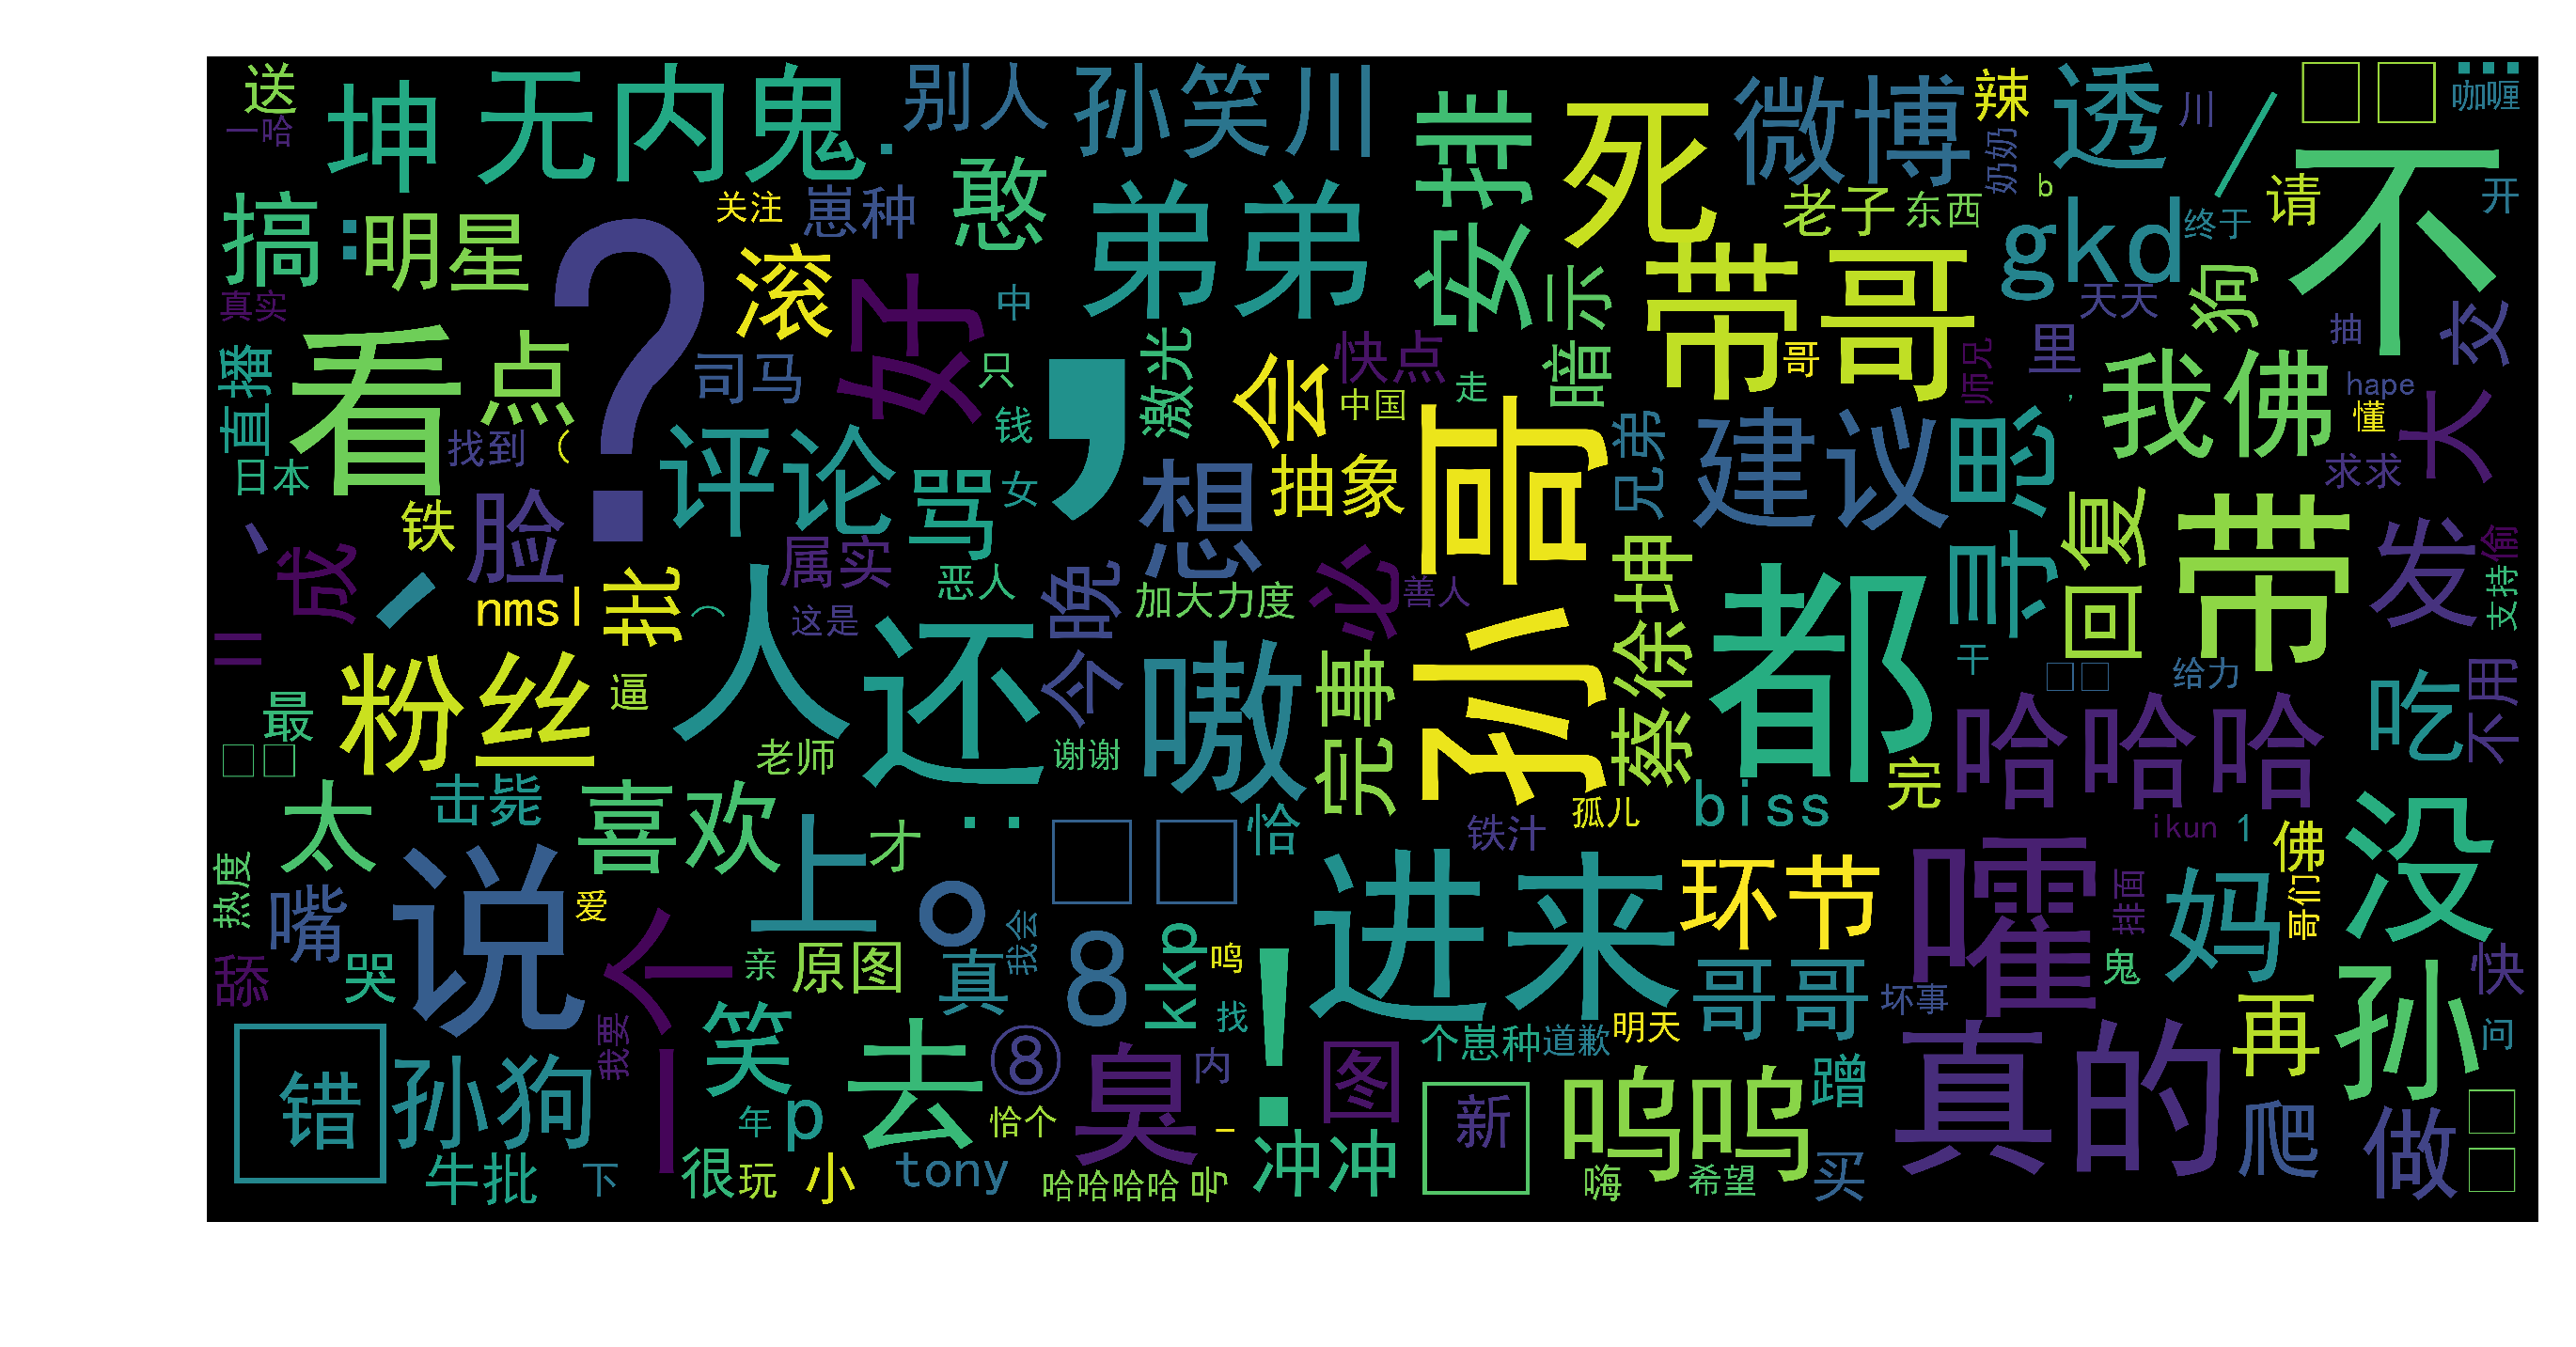

In [9]:
create_wordcloud(dict(word_count_jieba_without_stopword_sort)) 

# pkuseg库

In [10]:
seg = pkuseg.pkuseg(model_name='web')
word_count_pkusge = {}
for comment in comment_data:
    word_list_pkuseg = seg.cut(comment)
    word_count_pkusge = add_count(word_count_pkusge, word_list_pkuseg)

stopwords = stopwordslist('停用词表.txt')
word_count_pkuseg_without_stopword = {}
for word, freq in word_count_pkusge.items():
    if word not in stopwords:
        word_count_pkuseg_without_stopword[word] = freq

word_count_pkuseg_without_stopword_sort = sorted(word_count_pkuseg_without_stopword.items(),
                                          key=lambda item: int(item[1]),
                                          reverse=True)


In [11]:
print(word_count_pkuseg_without_stopword_sort[:100]) #查看前一百的词频

[('，', 659348), ('？', 372157), ('不', 160808), ('。', 97212), ('都', 81967), ('！', 79449), ('人', 67155), ('孙哥', 63024), ('说', 61053), ('看', 60756), ('还', 58857), ('没', 52242), ('进来', 48118), ('带哥', 41815), ('带', 40351), ('会', 39543), ('好', 37616), ('嗷', 37112), ('太', 34904), ('想', 34747), ('死', 32733), ('去', 31248), ('一个', 29765), ('真的', 29597), ('无', 29380), ('微博', 28206), ('佛', 27800), ('上', 27311), ('内鬼', 27290), ('真', 26333), ('建议', 24284), ('弟弟', 23749), ('8', 23205), ('粉丝', 22594), ('安排', 22399), ('孙', 21657), ('发', 20332), ('gkd', 19843), ('丶', 19670), ('必', 18800), ('️', 18761), ('寻思', 18123), ('透', 17707), ('评论', 17681), ('批', 17224), ('再', 16754), ('¿', 16600), ('吃', 16478), ('喜欢', 16440), ('：', 16176), ('小', 15962), ('滚', 15767), ('、', 15570), ('做', 15347), ('呜呜', 15065), ('点', 15047), ('孙笑川', 15032), ('孙狗', 14795), ('环节', 14763), ('图', 14586), ('这是', 14036), ('妈', 14024), ('笑', 14015), ('嚯嚯', 13936), ('次', 13867), ('骂', 13836), ('回复', 13772), (':', 13528), ('最', 13508), ('很', 

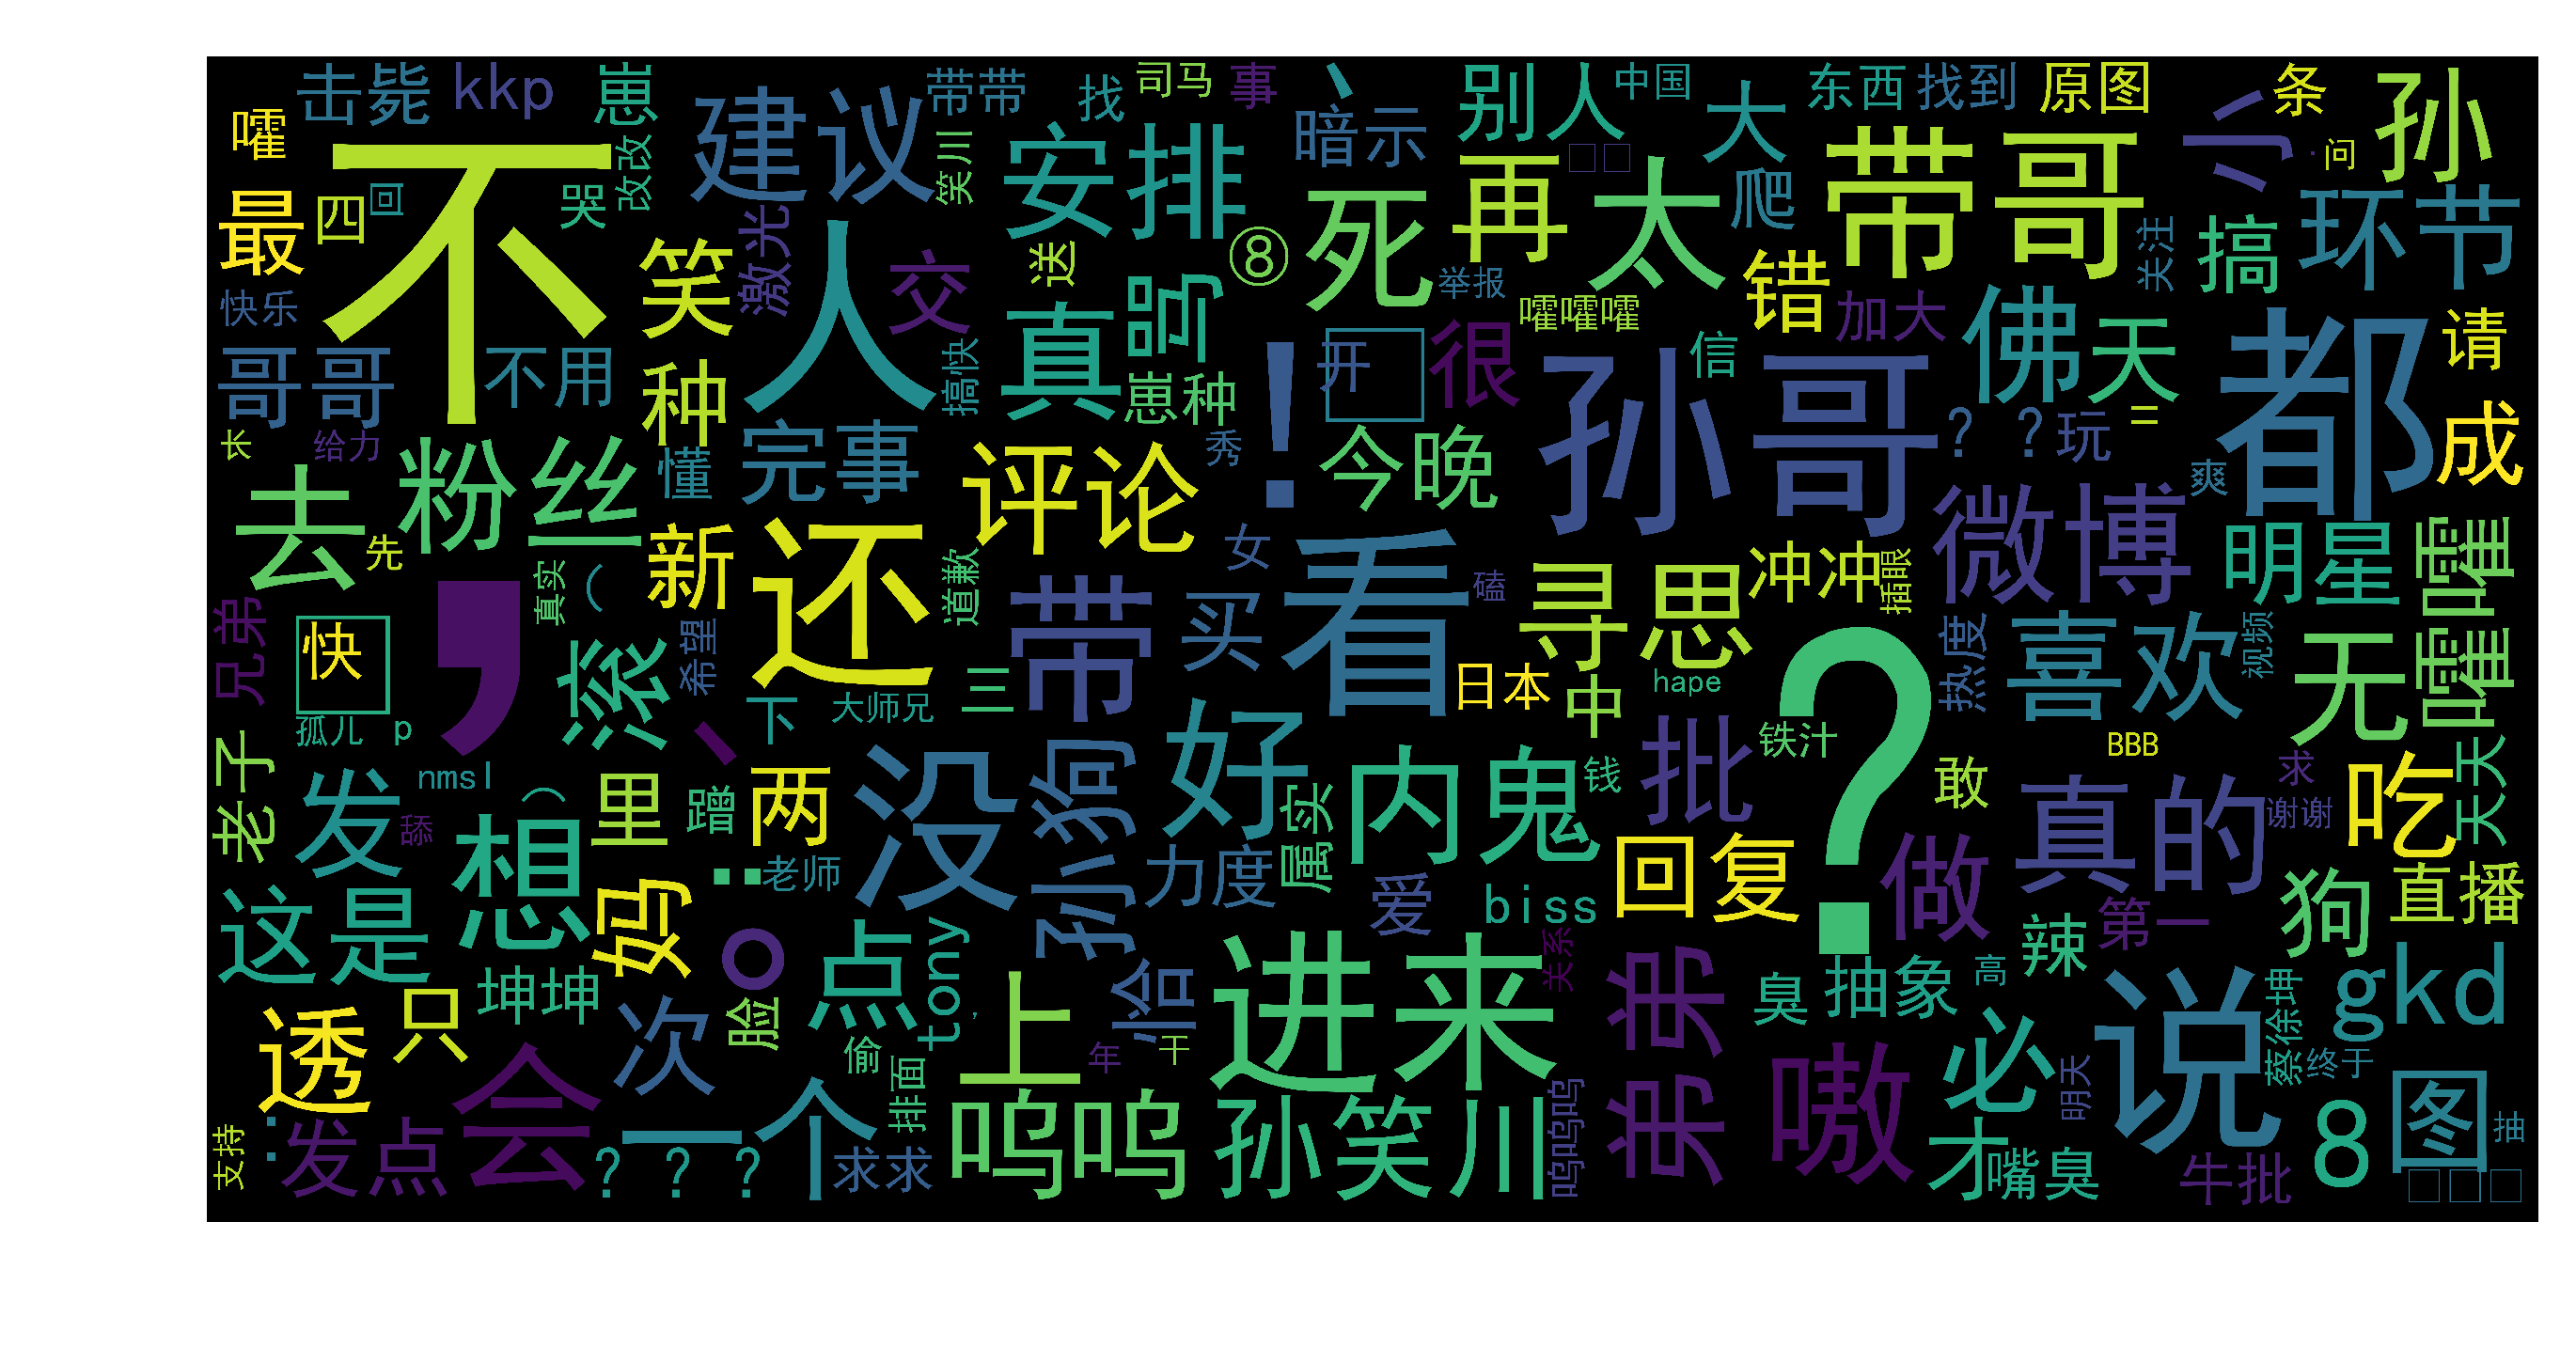

In [12]:
create_wordcloud(dict(word_count_pkuseg_without_stopword_sort)) 

可以看到，虽然分词可以提取出一些抽象话中的动词还有特殊符号（如“¿”），但是其中夹杂了许多标点符号与emoji，提取出的词语也更加短。这使得提取的词更琐碎，不利于观察。而关键词提取则很好的提取出了抽象话中的名词关键词（甚至如8000，biss等），可视化效果更好。

如果想要白色背景的词云可以将“# background_color="white",”注释掉。不过个人感觉黑色更好一点。

最后，给词云套一个背景图，一下子就儒雅随和起来了：

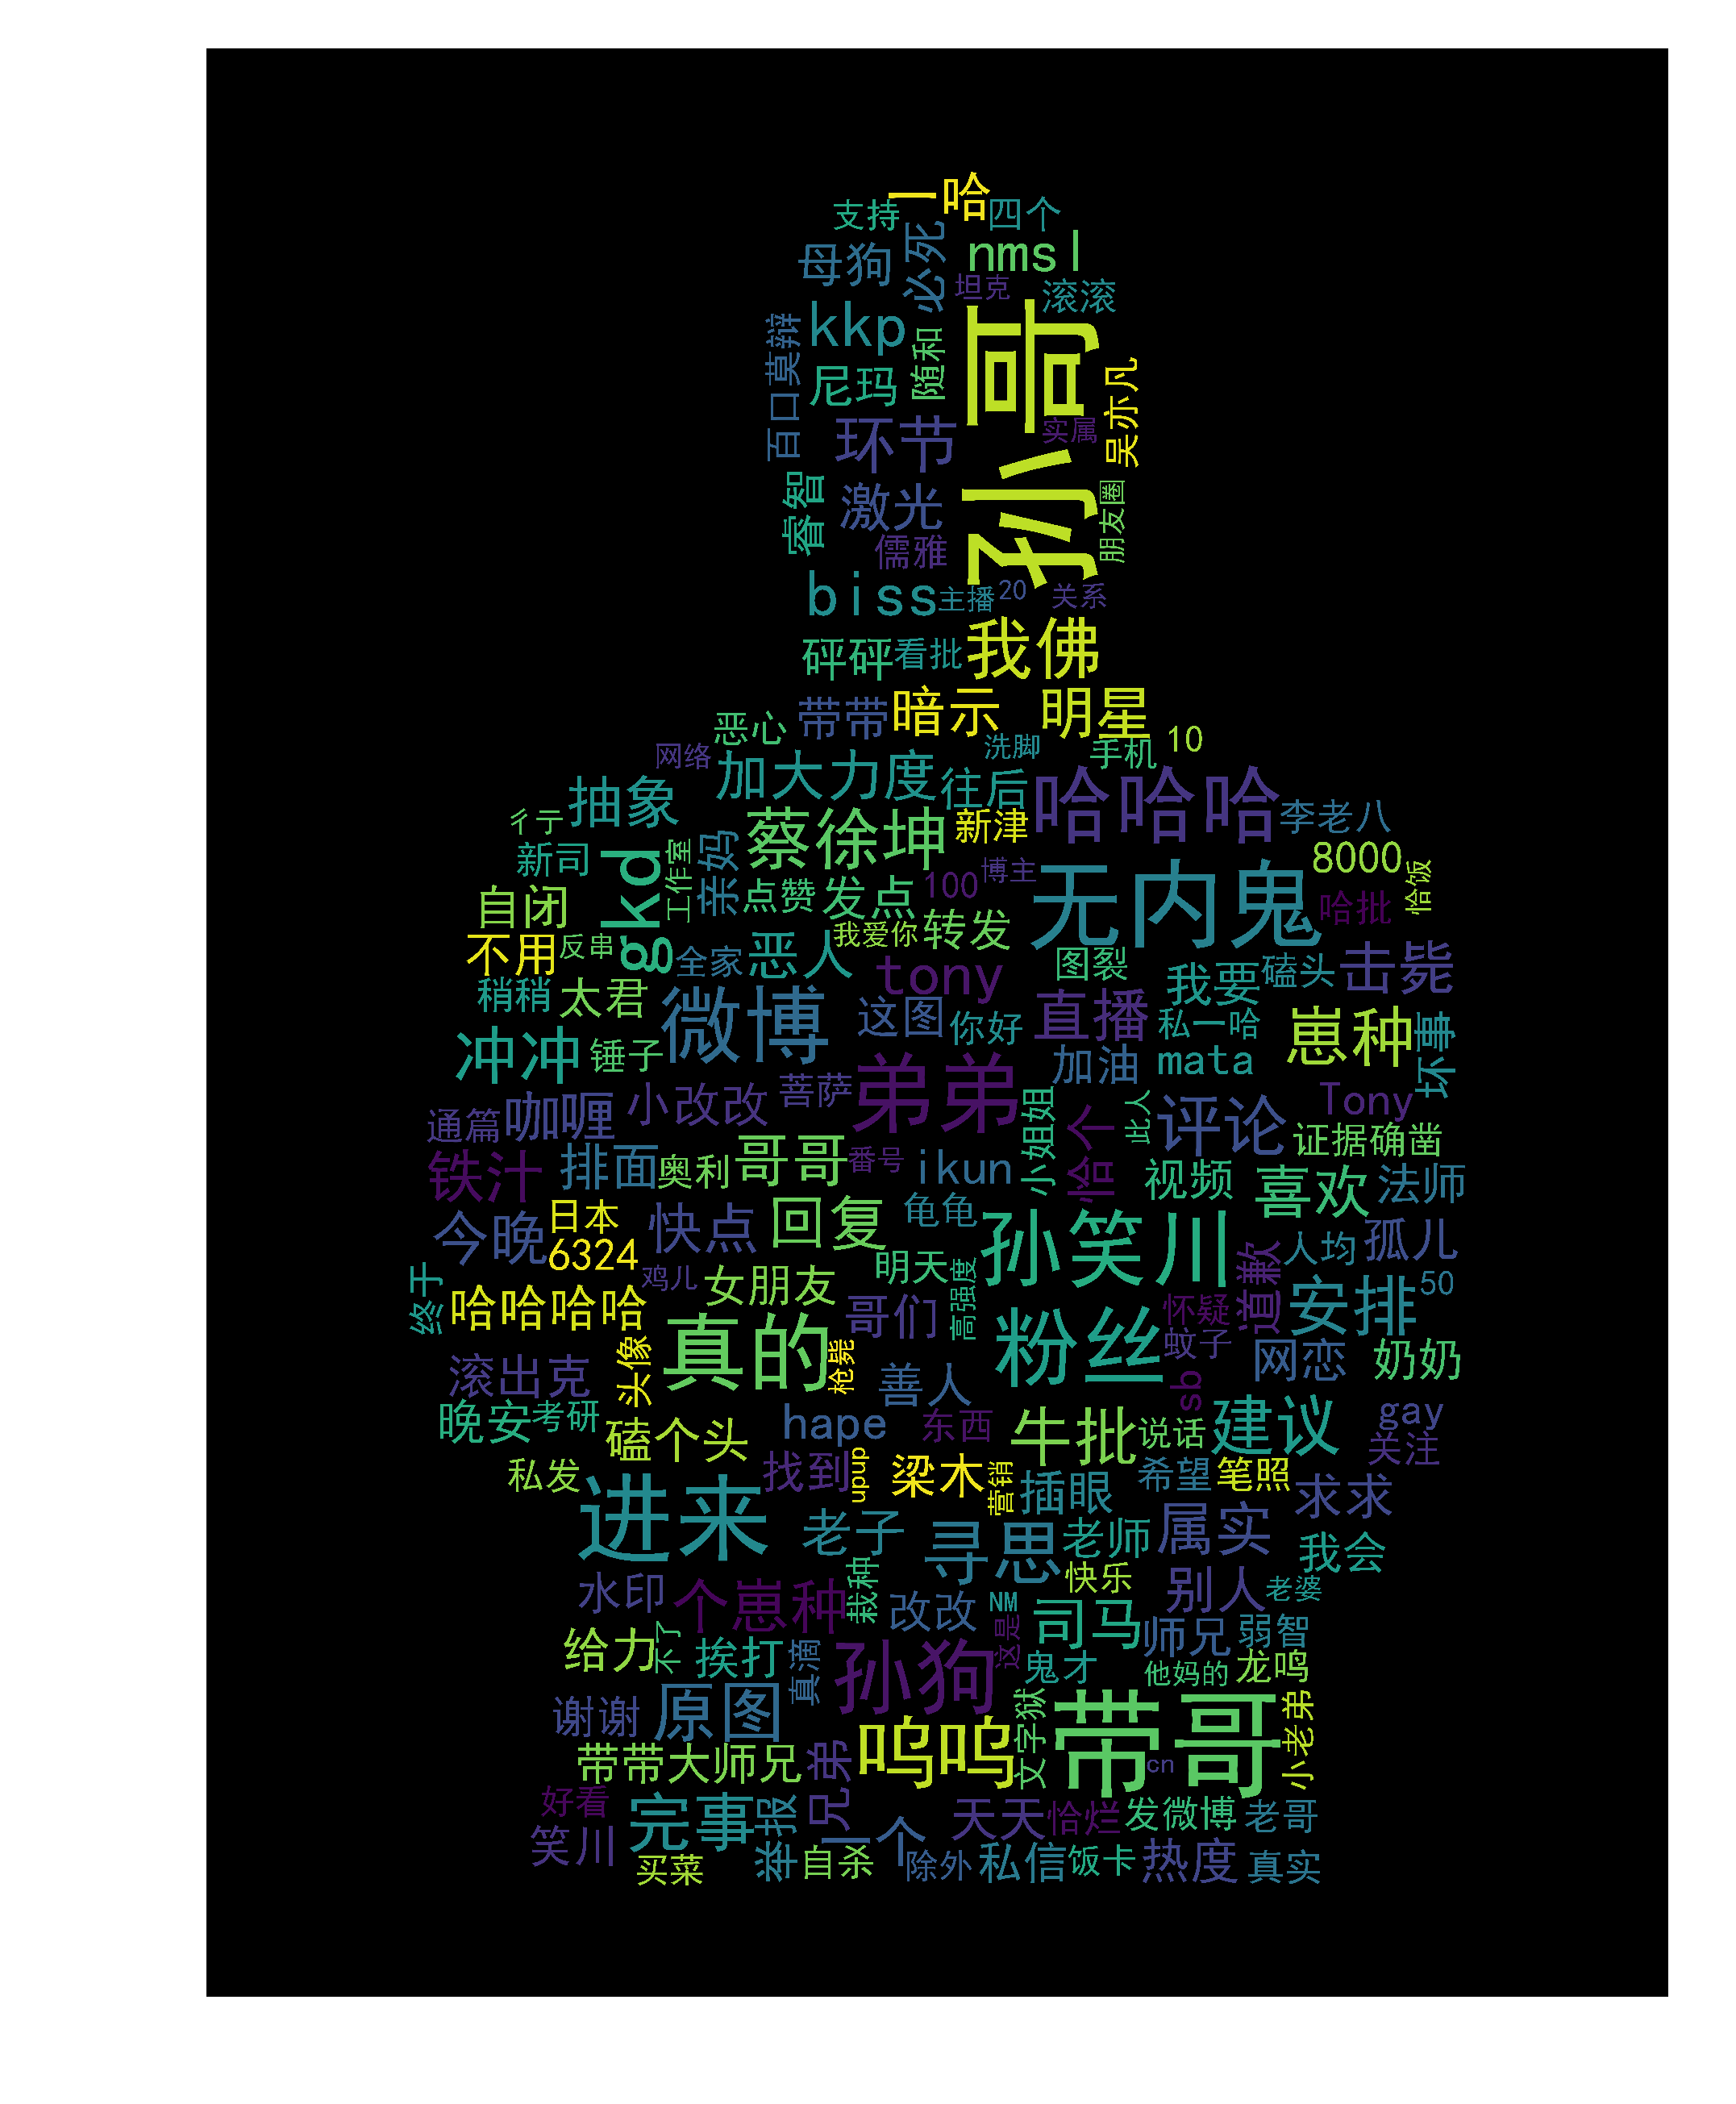

In [13]:
create_wordcloud(dict(tags), mask = 'sxc-mask.jpg', save_name='sxc-wordcloud.png')